## Использование методов PCA и SVM на MNIST-датасете

In [16]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from time import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import math

Вспомогательные функции.

In [17]:
# Plots the image represented by a row
def plot_number(row, w=28, h=28, labels=True):
    if labels:
        # the first column contains the label
        label = row[0]
        # The rest of columns are pixels
        pixels = row[1:]
    else:
        label = ''
        # The rest of columns are pixels
        pixels = row[0:]
    
    # Make those columns into a array of 8-bits pixels
    # This array will be of 1D with length 784
    # The pixel intensity values are integers from 0 to 255
    pixels = 255-np.array(pixels, dtype='uint8')

    # Reshape the array into 28 x 28 array (2-dimensional array)
    pixels = pixels.reshape((w, h))

    # Plot
    if labels:
        plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')

# Plots a whole slice of pictures
def plot_slice(rows, size_w=28, size_h=28, labels=True):
    num = rows.shape[0]
    w = 4
    h = math.ceil(num / w)
    fig, plots = plt.subplots(h, w)
    fig.tight_layout()

    for n in range(0, num):
        s = plt.subplot(h, w, n+1)
        s.set_xticks(())
        s.set_yticks(())
        plot_number(rows.iloc[n], size_w, size_h, labels)
    plt.show()

Загрузка тренировочного набора.

In [18]:
train = pd.read_csv('input/train.csv')
print(train.shape)

(42000, 785)


Вывод 5 строк из загруженного массива.

In [19]:
train.sample(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
10017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37489,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13022,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40507,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28906,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Описание загруженных данных.

In [20]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


Вывод нескольких первых рядов массива.

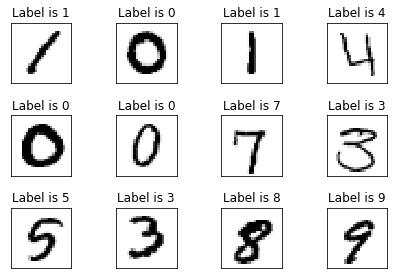

In [22]:
plot_slice(train[0:12])

Уменьшение размерности.

In [23]:
X_train = train.drop(['label'], axis='columns', inplace=False)
y_train = train['label']

from sklearn.model_selection import train_test_split
X_tr, X_ts, y_tr, y_ts = train_test_split(X_train, y_train, test_size=0.30, random_state=4)

In [24]:
n_components = 16
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

X_train_pca = pca.transform(X_train)

done in 6.225s


Гистограмма отклонений.

0.5953474251383517

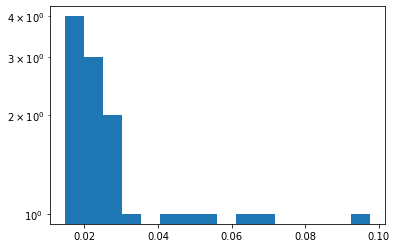

In [25]:
plt.hist(pca.explained_variance_ratio_, bins=n_components, log=True)
pca.explained_variance_ratio_.sum()

Вывод уменьшенных изображений.

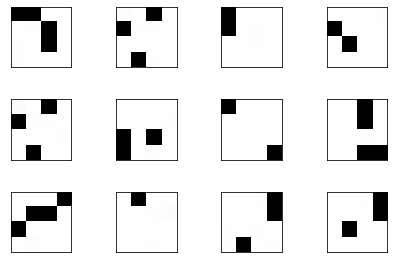

In [26]:
plot_slice(pd.DataFrame(data=X_train_pca[0:12]), size_w=4, size_h=4, labels=False)

In [27]:
param_grid = { "C" : [0.1], "gamma" : [0.1]}
rf = SVC()
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1, verbose=1)
gs = gs.fit(X_train_pca, y_train)

print(gs.best_score_)
print(gs.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
0.9428571428571428
{'C': 0.1, 'gamma': 0.1}


In [28]:
bp = gs.best_params_

t0 = time()
clf = SVC(C=bp['C'], kernel='rbf', gamma=bp['gamma'])
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))

done in 89.686s


In [29]:
clf.score(pca.transform(X_ts), y_ts)

0.9569047619047619

In [30]:
val = pd.read_csv('input/test.csv')
pred = clf.predict(pca.transform(val))
# ImageId,Label

val['Label'] = pd.Series(pred)
val['ImageId'] = val.index + 1
sub = val[['ImageId','Label']]

sub.to_csv('submission.csv', index=False)